# Deep learning tests

## Load libraries and data

In [2]:
import scipy.io as scio
from scipy.interpolate import CubicSpline
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.linear_model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import tqdm

In [3]:
import blosc
import pickle
def decompress(file,prealloc_arr=None):
    f=open(file,"rb")
    shape,arr_size,dtype,is_f_contiguous,num_chunks,max_num=pickle.load(f)

    if prealloc_arr is None:
        arr=np.empty(arr_size,dtype)
    else:
        arr=np.frombuffer(prealloc_arr.data, dtype=dtype, count=arr_size)

    for i in range(num_chunks):
        size=np.fromfile(f,np.uint32,count=1)
        c=f.read(size[0])
        blosc.decompress_ptr(c, arr[max_num*i:].__array_interface__['data'][0])
    f.close()

    #reshape
    if is_f_contiguous:
        arr=arr.reshape(shape[::-1]).T
    else:
        arr=arr.reshape(shape)
    return arr

In [4]:
import mat73
data3_1 = scio.loadmat('../Data/tissue3_1.mat')
data8_1 = scio.loadmat('../Data/tissue8_1.mat')
data13 = mat73.loadmat('../Data/tissue_t13_workspace.mat')
data17 = mat73.loadmat('../Data/tissue_t17_workspace.mat')
data39_1 = scio.loadmat('../Data/tissue39_1.mat')

no_baseline_3_1   = decompress('../Preprocessed/t3_1.lz4')
no_baseline_8_1   = decompress('../Preprocessed/t8_1.lz4')
no_baseline_13    = decompress('../Preprocessed/t13.lz4')
no_baseline_17    = decompress('../Preprocessed/t17.lz4')
no_baseline_39_1  = decompress('../Preprocessed/t39_1.lz4')

In [3]:
int_tissue_5 = data3_1['tissue_t3_1'].copy()
for i in range(200):
    for j in range(200):
        int_tissue_5[i,j] = int(data5['tissue_t5_1'][i,j]) 

tissue_train = [
    (data3_1['map_t3'], data3_1['tissue_t3_1']),
    (data4['map_t4'],   data4['tissue_t4']    ), 
    (data5['map_t5_1'], int_tissue_5  ),
    (data6['map_t6'],   data6['tissue_t6']    ),
    (data14['map_t14'], data14['tissue_t14']  ),
]

tissue_test = [
    (data3_2['map_t3'], data3_2['tissue_t3_2']),
    (data24['map_t24'], data24['tissue_t24']  )
]
 

### PCA dim reduction

In [5]:
from random import randint
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
def my_pca_rand(tissue, pca_components):
    pca_training_data = np.zeros((1000,1024))
    
    count = 0
    for (t_map,t_bcc) in tissue:
        count1 = 0    
        for _ in range(50):  
            i = randint(0,199)
            j = randint(0,199)
            if count < 1000 and count1 < 50:
                pca_training_data[count,:] = t_map[i,j,:]
                count  += 1
                count1 += 1
                        
    ### Perform PCA dimensionality reduction ###
    norm_data = normalize(pca_training_data)
    pca = PCA(n_components=pca_components) 
    pca.fit(norm_data)

    final_tissue = []
    for (t_map,t_bcc) in tissue:
        transformed = np.zeros((200,200,pca_components))
        for i in range(200):
            transformed[i,:,:] = pca.transform(t_map[i,:,:])
            
        final_tissue.append((transformed, t_bcc))
        
    return final_tissue


In [6]:
tissue = [
    (no_baseline_3_1, data3_1['bcc']),
    (no_baseline_8_1, data8_1['bcc']),
    (no_baseline_13,  data13['bcc']),
    (no_baseline_17,  data17['bcc']),
    (no_baseline_39_1, data39_1['bcc']),
]

tissue = my_pca_rand(tissue, 50)

tissue_train = tissue[:3]
tissue_test  = tissue[3:]

## Define Network

### SegNet structure

Encoder (5 steps):
1. Convolution with a filter bank
2. Normalisation & ReLU
3. Repeat 1&2 2/3 times
4. Max pooling: 2x2, stride=2 & store indices before subsampling

Decoder (5 steps):
1. Upsampling using stored indices
2. Convolution with a filter bank
3. Normalisation & ReLU
4. Repeat 2&3 2/3 times
    
A final step:
1. Softmax classifier

In [7]:
class Conv(nn.Module):
    """
    2/3 rounds of...
    - 2D convolution
    - Batch normalisation
    - ReLU
    """

    def __init__(self, num_conv, in_channels, out_channels, mid_channels=None):
        super().__init__()
        self.out_channels = out_channels
        if in_channels>out_channels:
            mid_channels = out_channels + (in_channels-out_channels)//2
        else:
            mid_channels = in_channels + (out_channels-in_channels)//2
        
        if num_conv == 2:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding='same'),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding='same'), 
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        if num_conv == 3:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding='same'),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding='same'),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding='same'), 
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.conv(x)

In [8]:
class Down(nn.Module):
    """
    One step of the contracting path:
    - Max pooling (downscaling)
    - Double convolution
    """

    def __init__(self, num_conv, in_channels, out_channels):
        super().__init__()
        self.conv_maxpool = nn.Sequential(
            Conv(num_conv, in_channels, out_channels),
            nn.MaxPool2d(2, stride=2,return_indices=True)  
        )

    def forward(self, x):
        return self.conv_maxpool(x)

There are a few ways of upsampling such as Nearest Neighbor, Bilinear Interpolation, and Transposed Convolution from simplest to more complex.
https://developers.arcgis.com/python/guide/how-unet-works/

In [9]:
class Up(nn.Module):
    """
    One step of the expansive path:
    - Upsampling with convolution
    - Double convolution
    """

    def __init__(self, num_conv, in_channels, out_channels):
        super().__init__()
        self.unpool = nn.MaxUnpool2d(2,stride=2)
        self.conv   = Conv(num_conv, in_channels, out_channels)
        
    def forward(self, x, ind):
        x = self.unpool(x, ind)
        return self.conv(x)

In [10]:
class SegNet(nn.Module):
    ''' 
    Input should be of size (N,Cin,H,W) = (1,1024,192,192)
    Output should be of size (N,Cout,H,W) = (1,16,192,192)
    '''

    def __init__(self, n_channels, n_classes):
        super(SegNet, self).__init__()
        self.down1 = Down(2, n_channels, 64)
        self.down2 = Down(2, 64, 128)
        self.down3 = Down(3, 128, 256)
        self.down4 = Down(3, 256, 512)
        self.down5 = Down(3, 512, 1024)
        self.up1 = Up(3, 1024, 512)
        self.up2 = Up(3, 512, 256)
        self.up3 = Up(3, 256, 128)
        self.up4 = Up(2, 128, 64)
        self.up5 = Up(2, 64, n_classes)
        self.out = nn.Softmax2d()

    def forward(self, x):
        x, indices1 = self.down1(x)
        x, indices2 = self.down2(x)
        x, indices3 = self.down3(x)
        x, indices4 = self.down4(x)
        x, indices5 = self.down5(x)
        x = self.up1(x, indices5)
        x = self.up2(x, indices4)
        x = self.up3(x, indices3)
        x = self.up4(x, indices2)
        x = self.up5(x, indices1)
        return self.out(x)

## Model Training

In [11]:
def train_model(model, data, target, PCA_COMP = 1024, num_epochs = 100):
                        
        # Make sure input image is large enough
        if min(target.shape) == 200:
                size = 192 
        if min(target.shape) == 100:
                size = 64 
        
        # Reshape matrix into array
        X = []
        for i in range(size):
                for j in range(size):
                        X.append(data[i,j,:])

        y = target[0:size,0:size].reshape(1,size,size)
        
        # Reshape data for test & train
        scaler = sklearn.preprocessing.StandardScaler()

        X = scaler.fit_transform(X)
        X = X.reshape(1,PCA_COMP,size,size)

        tensor_X = torch.Tensor(X)
        tensor_y = torch.Tensor(y).long()

        # Train model
        model.train();

        for _ in tqdm.trange(num_epochs):
                optimizer.zero_grad()
                y_pred = model(tensor_X)
                loss = criterion(y_pred, tensor_y)
                loss.backward()
                optimizer.step()

In [12]:
def test_model(model, data, target, PCA_COMP = 1024):
        # Make sure input image is large enough
        if min(target.shape) == 200:
                size = 192 
        if min(target.shape) == 100:
                size = 64 

        # Reshape matrix into array
        X = []
        for i in range(size):
                for j in range(size):
                        X.append(data[i,j,:])
        
        # Reshape data for test & train
        scaler = sklearn.preprocessing.StandardScaler()

        X = scaler.fit_transform(X)
        X = X.reshape(1,PCA_COMP,size,size)
        
        tensor_X = torch.Tensor(X)
        
        # Evaluate model
        model.eval();
        y_pred = model(tensor_X)
        
        # Create image from results
        results = []

        for i in range(size):
                for j in range(size):
                        array = y_pred[0,:,i,j].detach().numpy()
                        index = np.argmax(array)
                        results.append(index)
        
        approximation = np.zeros((size,size))
        for i in range(size):
                for j in range(size):
                        index = i*size + j
                        approximation[i,j] = results[index]
        
        # Plot images
        _, axs = plt.subplots(1,2, figsize=(10,5))
        axs[0].imshow(target)
        axs[0].title.set_text('Target')
        axs[1].imshow(approximation)
        axs[1].title.set_text('SegNet estimate')
        plt.show()

## Run SegNet

In [13]:
model = SegNet(50,2)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for (data, target) in tissue_train:
    train_model(model, data,target,PCA_COMP=50)

100%|██████████| 100/100 [06:06<00:00,  3.67s/it]


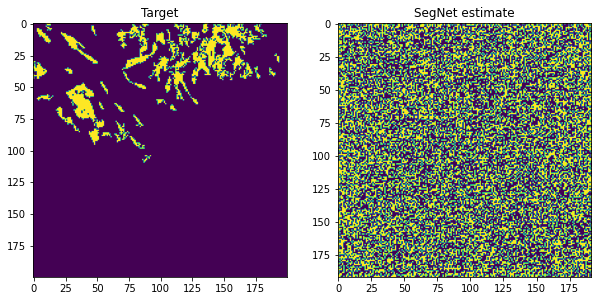

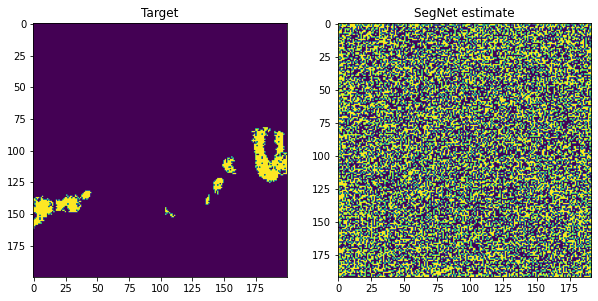

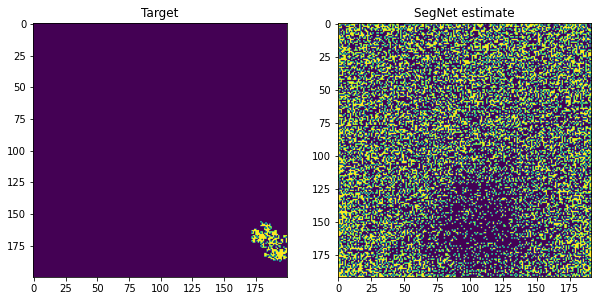

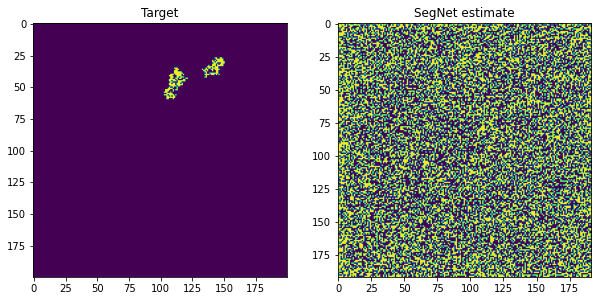

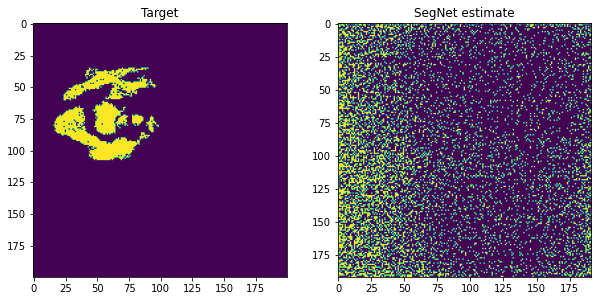

In [14]:
for (data, target) in tissue_train:
    test_model(model, data,target, PCA_COMP=50)
for (data, target) in tissue_test:
    test_model(model, data,target, PCA_COMP=50)